<a href="https://colab.research.google.com/github/WFirmin/Math/blob/main/Differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Differentiation

### Finite Differences
The following three functions implement common differentiation formulas: Forward Difference, Backward Difference, and Centered Difference approximation respectively.

Forward Difference:
$$f'(x)=\frac{f(x+h)-f(x)}{h}+\mathcal{O}(h)$$

Backward Difference:
$$f'(x)=\frac{f(x)-f(x-h)}{h}+\mathcal{O}(h)$$

Centered Difference:
$$f'(x)=\frac{f(x-h)-2f(x)+f(x+h)}{h^2}+\mathcal{O}(h^2)$$

In [12]:
# Required code from other parts of the main notebook:
import math
import numpy as np
import matplotlib.pyplot as plt
import time

# Numerical Linear Algebra: Gaussian Elimination for solving a linear system
def gaussian_elimination(A,b):
    A = A.copy()
    b = b.copy()
    for i in range(A.shape[1]):
        b[i] = b[i] / A[i,i]
        A[i,:] =  A[i,:]/A[i,i]
        if i < A.shape[1]-1:
            for j in range(i+1,A.shape[1]):
                b[j] = b[j] - A[j,i] * b[i]
                A[j,:] -= A[j,i] * A[i,:]
    for i in range(A.shape[1]-2,-1,-1):
        for j in range(i+1,A.shape[1]):
            b[i] = b[i] - A[i,j]*b[j]
            A[i,:] = A[i,:] - A[i,j] * A[j,:]
    return b


# Polynomial Interpolation: generation of Chebyshev Nodes
def ChebyshevNodes(a,b,n):
  nodes = np.sort(np.cos(np.linspace(0,math.pi,n)))
  return 0.5*((b-a)*nodes + a+b)

In [7]:
def ForwardDiff(f, x, h=1e-4):
  return (f(x+h) - f(x))/h

def BackwardDiff(f, x, h=1e-4):
  return (f(x) - f(x-h))/h

def CenteredDiff(f,x,h=1e-4):
  return (f(x-h) - 2*f(x) + f(x+h))/h**2


Taylor's Theorem can be used to derive more precise differentiation formulas for functions that are sufficiently smooth.  Below I derive and implement formulas for $n$ backward differences:

Taylor's Theorem directly gives that
$$f(x-h)=\sum_{i=0}^m\frac{(-h)^i}{i!}f^{(i)}(x)+\frac{(-h)^{m+1}}{(m+1)!}f^{(m+1)}(\zeta)$$
for some $\zeta\in(x-h,x)$.  Similarly, for $k\in\mathbb{N}$,
$$f(x-kh)=\sum_{i=0}^m\frac{(-kh)^i}{i!}f^{(i)}(x)+\frac{(-kh)^{m+1}}{(m+1)!}f^{(m+1)}(\zeta_k)$$

The goal is to combine the first $n$ of these formulas such that all terms after the first derivative (except for the error) cancel out.  This will give a formula for $f'(x)$ using evaluations of $f$ at multiple points, plus a higher-order error term $\mathcal{O}(h^{m})$.  By assigning each formula a coefficient $c_k$, we can solve for the needed coefficients with the following linear system of equations:

$$\begin{bmatrix}
-hf'(x) & -2hf'(x) & \dots & -nhf'(x) \\
\frac{h^2}2f''(x) & \frac{4h^2}2f''(x) & \dots & \frac{n^2h^2}2f''(x) \\
\dots & \dots & \dots & \dots \\
\frac{(-h)^m}{m!}f^{(m)}(x) & \frac{(-2h)^m}{m!}f^{(m)}(x) & \dots & \frac{(-nh)^m}{m!}f^{(m)}(x)
\end{bmatrix}\begin{bmatrix}
c_1 \\ c_2 \\ \dots \\ c_n
\end{bmatrix}=\begin{bmatrix}
1\\0\\\dots\\0
\end{bmatrix}$$

Which can be simplified to

$$\begin{bmatrix}
1&2&\dots&n\\
1&2^2&\dots&n^2\\
\dots&\dots&\dots&\dots\\
1&2^m&\dots&n^m
\end{bmatrix}\begin{bmatrix}
c_1\\c_2\\\dots\\c_n
\end{bmatrix}=\begin{bmatrix}
1\\0\\\dots\\0
\end{bmatrix}$$

The columns are linearly independent, and the system can be solved uniquely for $m=n$.  Notice that these coefficients only depend on $n$ and can thus be solved without $f$ or $h$.  I use Gaussian elimination in my implementation since $n$ is typically small and iterative methods aren't needed.  Multiplying each formula by its coefficient and summing gives

$$\sum_{i=1}^nc_if(x-ih)=f(x)\sum_{i=1}^nc_i-hf'(x)+\sum_{i=1}^n\frac{(-ih)^{n+1}c_i}{(n+1)!}f^{(n+1)}(\zeta_i)\\
\Downarrow\\
f'(x)=\frac1h\left[f(x)\sum_{i=1}^nc_i-\sum_{i=1}^nc_if(x-ih)\right]+\mathcal{O}(h^n)
$$

In [8]:
def BackwardsDiff(n):
  # Create the matrix shown above
  coef_mat = [np.arange(1,n+1)]
  for i in range(2,n+1):
    coef_mat.append(coef_mat[0] * coef_mat[-1])
  coef_mat = np.array(coef_mat)

  # Create the vector
  result_v = np.zeros(n)
  result_v[0] = 1

  # Solve for the coefficients
  coef_v = gaussian_elimination(coef_mat, result_v)

  # Return a function that gives the derivative based on the formula
  # The returned function takes inputs f, x, and h
  return lambda f, x, h=1e-4: 1/h*(f(x)*coef_v.sum() - coef_v.dot(np.array(list(map(f, x-h*np.arange(1,n+1))))))



We can test the method on a known derivative.  For this example, I use $f(x)=e^x$ evaluated at 0.  The derivative here is clearly 1.  I plot the log errors for forward difference and numerous orders of backward difference approximation.

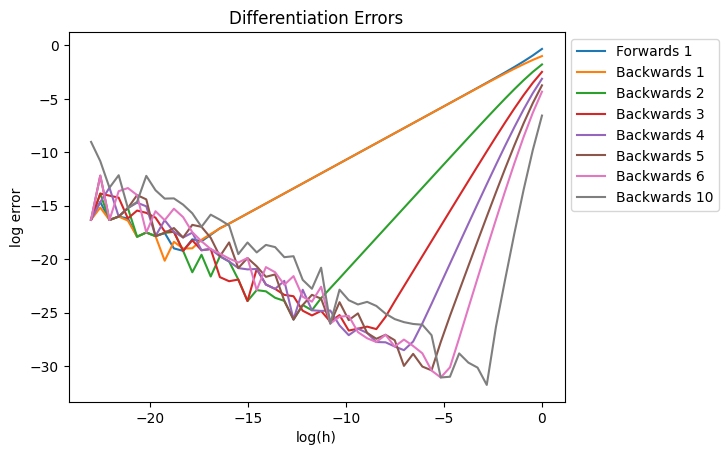

In [23]:
# Set the function f, point of evaluation z, and true derivative value
f = lambda x: math.e**x
z = 0
true = 1

# Define the values of h to test
H = 10**np.linspace(0,-10,50)

# Evaluate using forward difference
forward = np.log(np.abs(list(map(lambda h: true-ForwardDiff(f,z,h), H))))
plt.plot(np.log(H), forward, label="Forwards 1")

# Evaluate using backward differences, using 1-6 orders
backwards = []
for j in list(range(1,7))+[10]:
  fp = BackwardsDiff(j) # calculate coefficients, give formula
  backwards.append(np.log(np.abs(list(map(lambda h: true-fp(f,z,h),H)))))
  plt.plot(np.log(H), backwards[-1], label=f"Backwards {j}")

# Alter plot appearance
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("log(h)")
plt.ylabel("log error")
plt.title("Differentiation Errors")
plt.show()




Note that values further to the left represent smaller values of $h$.  When $h$ is still somewhat large, we can see that higher orders of backward difference approximations converge more rapidly to the true derivative of 1.  At a small enough interval, each method begins to lose accuracy from floating point error.  While this occurs sooner for the higher-order methods, their peak accuracy is still greater than the others'.  For the method with 6 backwards differences, the optimal value of $h$ would be around $e^{-5}$.  The method with only 1 backwards difference would be optimized at roughly $h=e^{-18}$ with error larger by a factor of $e^{11}$.  The order 10 method shows the decreasing marginal benefit as the orders increase.  For even higher orders, such as 15, the methods begin to break down.

### Polynomial Interpolant
Another powerful method for differentiation is finding a polynomial interpolant and differentiating the polynomial.  Below I implement a method for finding the derivative via polynomial interpolation (see interpolation section of main notebook).  Then I first test the method for different numbers of subintervals in a given interval.

In [10]:
def LagrangeBasisFnDiff(nodes, i, x):
  n = len(nodes)
  return np.array([1/(nodes[i]-nodes[j])*np.array([(x-nodes[k])/(nodes[i]-nodes[k]) for k in range(n) if k!=j and k!=i]).prod() for j in range(n) if j!=i]).sum()


def LagrangePolyDiff(f, nodes, x):
  f_eval = np.apply_along_axis(f,0,nodes)
  lp_eval = np.array(list(map(lambda i: LagrangeBasisFnDiff(nodes,i,x), range(len(nodes)))))
  return f_eval.dot(lp_eval)

[]

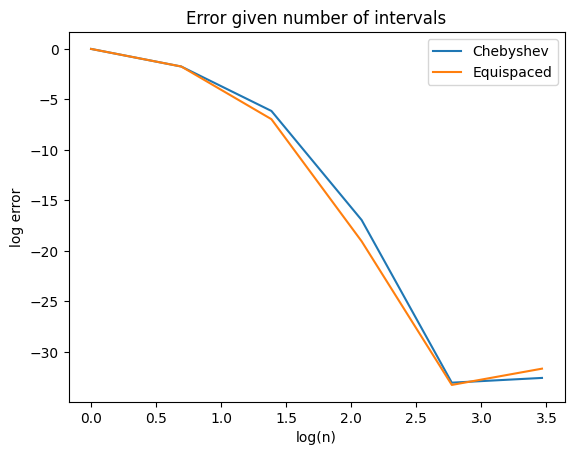

In [24]:
f = lambda x: math.e**x
z = 0
true = 1

cheby_diff = []
equi_diff = []

ns = 2**np.arange(0,6)

for n in ns:
  n = int(n)
  cheby_diff.append(LagrangePolyDiff(f, ChebyshevNodes(-1,1,n),z))
  equi_diff.append(LagrangePolyDiff(f,np.linspace(-1,1,n),z))

plt.plot(np.log(ns), np.log(np.abs(true-np.array(cheby_diff))), label="Chebyshev")
plt.plot(np.log(ns), np.log(np.abs(true-np.array(equi_diff))), label="Equispaced")
plt.legend()
plt.title("Error given number of intervals")
plt.xlabel("log(n)")
plt.ylabel("log error")
plt.plot()

Both the Chebyshev and equispaced nodes give similar approximations.  The error becomes quite small before bouncing back up.  Next I compare this to using a fixed number of subintervals and varying the size of each.

[]

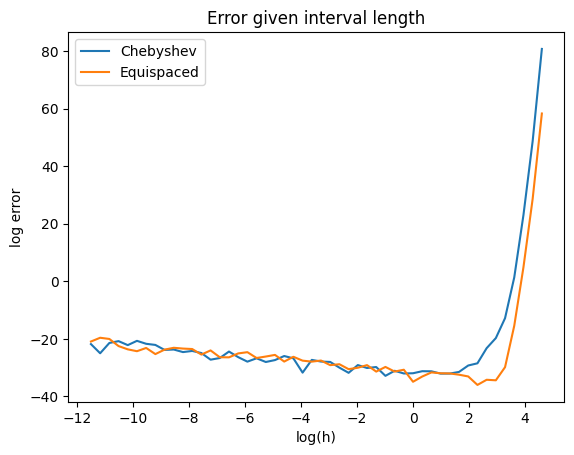

In [25]:
# interval size instead of nodes:
f = lambda x: math.e**x
z = 0
true = 1

cheby_diff = []
equi_diff = []

H = 10**np.linspace(2,-5,50)

for h in H:
  cheby_diff.append(LagrangePolyDiff(f, ChebyshevNodes(z-h,z+h,50),z))
  equi_diff.append(LagrangePolyDiff(f,np.linspace(z-h,z+h,50),z))

plt.plot(np.log(H), np.log(np.abs(true-np.array(cheby_diff))), label="Chebyshev")
plt.plot(np.log(H), np.log(np.abs(true-np.array(equi_diff))), label="Equispaced")
plt.legend()
plt.title("Error given interval length")
plt.xlabel("log(h)")
plt.ylabel("log error")
plt.plot()

We can see that the error quickly drops to a similar level as the previous method.  Both the Chebyshev and equispaced nodes give similar approximations again.  Both methods display the same pattern as the finite differences, where the problem becomes numerically unstable for smaller distances.  